## **Importing libraries and data**

In [2]:
import csv
import math
import pickle
import datetime as dt
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import sklearn

from scipy import stats
from dateutil.parser import parse
from datetime import datetime
from IPython.display import display_html
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from pprint import pprint
from sklearn.preprocessing import OrdinalEncoder
from catboost import CatBoostRegressor

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
plt.style.use('fivethirtyeight')
pd.options.display.float_format = '{:.2f}'.format

In [3]:
## Load ADS using name and path

load_ads = pd.read_csv('gs://aes-analytics-0002-curated/Outage_Restoration/Repredictions/Master_Dataset/OMS_IPL_V1.csv', index_col=0)
load_ads = load_ads[load_ads.TR>0]
load_ads['CREATION_DATETIME'] = pd.to_datetime(load_ads['CREATION_DATETIME'], infer_datetime_format = True, errors = 'coerce')

# Getting info for training dataset
event_id = load_ads['EVENT']
outage_id = load_ads[['OUTAGE_ID', 'INCIDENT_ID', 'STRCTUR_NO', 'EVENT', 'CREATION_DATETIME', 'ENERGIZED_DATETIME',
                        'CIRCT_ID', 'SUBST_ID', 'ETR_DATETIME', 'Marker_Location', 'RANK_SUBSEQUENT_OUTAGES', 'LAT', 'LONG', 'Live_outage_group']]

# Dropping unnecessary columns
load_ads.drop(columns= ['OUTAGE_ID', 'INCIDENT_ID', 'STRCTUR_NO', 'EVENT', 'CREATION_DATETIME', 'ENERGIZED_DATETIME',
                        'ETR_DATETIME', 'Marker_Location', 'RANK_SUBSEQUENT_OUTAGES', 'LAT', 'LONG', 'Live_outage_group'], inplace=True)
print(load_ads.shape)
display(load_ads.head())

(561196, 149)


,CIRCT_ID,DNI_EQUIP_TYPE,SUBST_ID,CALL_QTY,DOWNSTREAM_CUST_QTY,KEY_CUST_QTY,CUST_QTY,DAY_FLAG,POLE_CLUE_FLG,PART_LIGHT_CLUE_FLG,EMERGENCY_CLUE_FLG,POWER_OUT_CLUE_FLG,OPEN_DEVICE_CLUE_FLG,TREE_CLUE_FLG,WIRE_DOWN_CLUE_FLG,IVR_CLUE_FLG,EQUIPMENT_CLUE_FLG,TRANSFORMER_CLUE_FLG,OH_CAUSE_FLG,UG_CAUSE_FLG,ANIMAL_CAUSE_FLG,WEATHER_CAUSE_FLG,WEATHER_COLD_CAUSE_FLG,PUBLIC_CAUSE_FLG,WEATHER_LIGHTNING_CAUSE_FLG,WEATHER__SNOW_CAUSE_FLG,WEATHER__WIND_CAUSE_FLG,WEATHER__HEAT_CAUSE_FLG,CUST_REQUEST_CAUSE_FLG,WEATHER__FLOOD_CAUSE_FLG,STREET_CAUSE_FLG,SUBSTATION_CAUSE_FLG,TREE_CAUSE_FLG,MISCELLANEOUS_CAUSE_FLG,NO_CAUSE_FLG,PLANNED_CAUSE_FLG,NO_OUTAGE_CAUSE_FLG,FUSE_OCCURN_FLG,CUST_EQUIP_OCCURN_FLG,POLE_OCCURN_FLG,TRANSFORMER_OCCURN_FLG,METER_OCCURN_FLG,SERVICE_OCCURN_FLG,CABLE_OCCURN_FLG,ST_OCCURN_FLG,FIRE_OCCURN_FLG,FOUND_OPEN_OCCURN_FLG,PUBLIC_SAFETY_OCCURN_FLG,WIRE_OCCURN_FLG,SWITCH_OCCURN_FLG,REGULATOR_OCCURN_FLG,CUTOUT_OCCURN_FLG,CAP_BANK_OCCURN_FLG,RECLOSER_OCCURN_FLG,OH_OCCURN_FLG,PRIORITY_VAL_1.0,PRIORITY_VAL_2.0,PRIORITY_VAL_3.0,PRIORITY_VAL_5.0,CITY_NAM,ZONE,NO_OF_POWER_OUT_CLUE_PER_DAY,NO_OF_OPEN_DEVICE_CLUE_PER_DAY,NO_OF_IVR_CLUE_PER_DAY,NO_OF_ANIMAL_CAUSE_PER_DAY,NO_OF_WIRE_OCCURN_PER_DAY,Hour_Sin,Hour_Cos,LIVE_OUTAGE,Outages_in_last_1hr,Outages_in_last_2hr,Outages_in_last_3hr,Outages_in_last_4hr,Outages_in_last_5hr,Outages_in_last_6hr,Outages_in_last_7hr,Outages_in_last_8hr,Outages_in_last_9hr,Outages_in_last_10hr,Weekday,Weekend_flag,Priority_Customer_Qty,Dis_From_Live_Centriod_div_Cust_qty,Priority_Dist_Customer_Qty,Dispatch_Location,cldCvrAvg,cldCvrMax,cldCvrMin,dewPtAvg,dewPtMax,dewPtMin,feelsLikeAvg,feelsLikeMax,feelsLikeMin,heatIndexAvg,heatIndexMax,heatIndexMin,mslPresAvg,mslPresMax,mslPresMin,precip,radSolarAvg,radSolarMax,radSolarTot,relHumAvg,relHumMax,relHumMin,sfcPresAvg,sfcPresMax,sfcPresMin,snowfall,spcHumAvg,spcHumMax,spcHumMin,tempAvg,tempMax,tempMin,wetBulbAvg,wetBulbMax,wetBulbMin,windChillAvg,windChillMax,windChillMin,windDir100mAvg,windDir80mAvg,windDirAvg,windSpd100mAvg,windSpd100mMax,windSpd100mMin,windSpd80mAvg,windSpd80mMax,windSpd80mMin,windSpdAvg,windSpdMax,windSpdMin,tempRange,windSpdRange,sfcPresRange,cldCvrRange,relHumRange,relHumRatio,sfcPresRatio,Time_Since_Outage,TR,Slope_outages,Slope_ROC_outages,max_ROC_outages,max_index_ROC,weight_ROC
0,3059.00,SSUB,305.00,4,177.00,1.00,177.00,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,True,False,False,False,INDIANAPOLIS,ZONE3,7,1,5,2,1,0.71,0.71,0,0,0,0,0,0,0,0,0,0,0,Monday,False,1.00,0.00,1.00,ARL.,92.00,100.00,44.00,33.90,39.50,30.00,30.30,36.70,24.30,38.50,43.70,34.50,1016.40,1026.00,1008.90,0.00,28.50,125.40,684.30,83.30,90.30,79.30,986.80,995.80,980.10,0.00,4.20,5.20,3.60,38.50,43.70,34.50,36.60,41.70,32.80,30.30,36.70,24.30,269.00,269.00,267.00,16.80,20.30,8.80,17.00,20.60,8.90,14.40,17.80,6.70,9.20,11.10,15.70,56.00,11.00,1.14,1.02,0.00,15.00,nan,nan,0,1,0.00
1,1958.00,1TBOH,195.00,2,6.00,0.00,6.00,True,False,False,False,True,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,INDIANAPOLIS,ZONE4,7,1,5,2,1,0.71,-0.71,1,0,1,1,1,1,1,2,2,2,2,Monday,False,1.00,0.66,1.00,MILL,90.00,100.00,42.00,33.50,39.10,29.70,29.80,36.00,23.80,38.10,42.90,34.10,1016.70,1026.10,1009.30,0.00,29.50,130.10,707.00,83.70,90.00,79.00,987.90,996.80,981.30,0.00,4.10,5.20,3.50,38.10,42.90,34.10,36.20,41.10,32.40,29.80,36.00,23.80,269.00,269.00,267.00,16.60,20.30,8.80,16.80,20.50,8.90,14.30,17.80,6.70,8.80,11.10,15.50,58.00,11.00,1.14,1.02,0.00,39.60,4.02,-1.93,1,1,0.10
2,1958.00,1TBOH,195.00,2,6.00,0.00,6.00,True,False,False,Fa

In [4]:
load_ads.dropna(subset=['Slope_ROC_outages', 'Slope_outages'],inplace=True)

In [5]:
# calculate rmse scores
def rmse(pred_test, y_test):
    return np.sqrt(((pred_test - y_test) ** 2).mean())

# calculate mape scores
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def do_union(lst1, lst2, lst3, lst4): 
    final_list = list(set(lst1) | set(lst2) | set(lst3) | set(lst4))
    return final_list 

### **Distribution and transformation of Y-variable**

### **Target Variable Analysis: Is it Normal?**

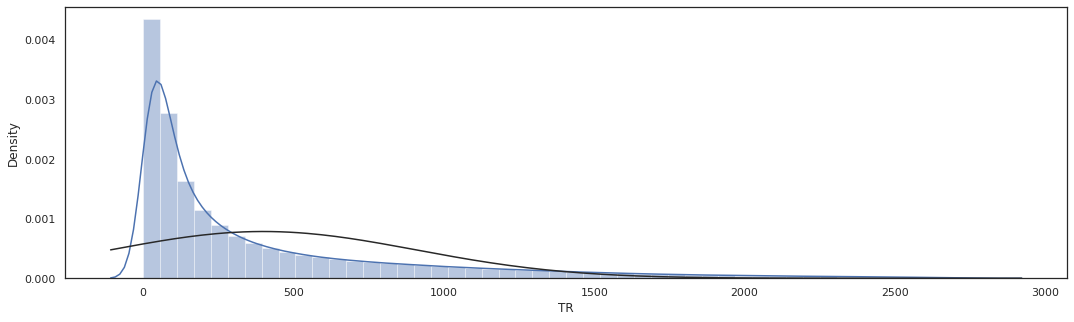

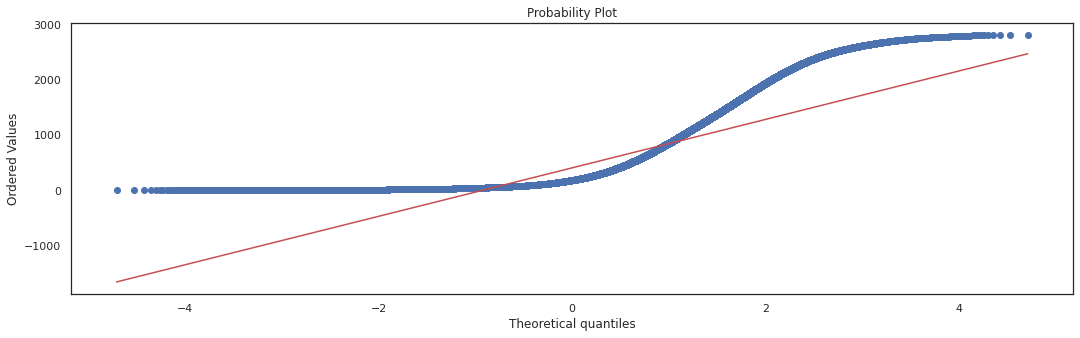

In [6]:
from scipy.stats import norm

sns.set(rc={'figure.figsize':(16,5)})
sns.set_style("white")

sns.distplot(load_ads['TR'],fit=norm);
fig = plt.figure()
res = stats.probplot(load_ads['TR'], plot=plt)

In [7]:
object_columns = load_ads.loc[:, (load_ads.dtypes == object) | (load_ads.dtypes == bool)]
print(list(object_columns.columns))

['DNI_EQUIP_TYPE', 'DAY_FLAG', 'POLE_CLUE_FLG', 'PART_LIGHT_CLUE_FLG', 'EMERGENCY_CLUE_FLG', 'POWER_OUT_CLUE_FLG', 'OPEN_DEVICE_CLUE_FLG', 'TREE_CLUE_FLG', 'WIRE_DOWN_CLUE_FLG', 'IVR_CLUE_FLG', 'EQUIPMENT_CLUE_FLG', 'TRANSFORMER_CLUE_FLG', 'OH_CAUSE_FLG', 'UG_CAUSE_FLG', 'ANIMAL_CAUSE_FLG', 'WEATHER_CAUSE_FLG', 'WEATHER_COLD_CAUSE_FLG', 'PUBLIC_CAUSE_FLG', 'WEATHER_LIGHTNING_CAUSE_FLG', 'WEATHER__SNOW_CAUSE_FLG', 'WEATHER__WIND_CAUSE_FLG', 'WEATHER__HEAT_CAUSE_FLG', 'CUST_REQUEST_CAUSE_FLG', 'WEATHER__FLOOD_CAUSE_FLG', 'STREET_CAUSE_FLG', 'SUBSTATION_CAUSE_FLG', 'TREE_CAUSE_FLG', 'MISCELLANEOUS_CAUSE_FLG', 'NO_CAUSE_FLG', 'PLANNED_CAUSE_FLG', 'NO_OUTAGE_CAUSE_FLG', 'FUSE_OCCURN_FLG', 'CUST_EQUIP_OCCURN_FLG', 'POLE_OCCURN_FLG', 'TRANSFORMER_OCCURN_FLG', 'METER_OCCURN_FLG', 'SERVICE_OCCURN_FLG', 'CABLE_OCCURN_FLG', 'ST_OCCURN_FLG', 'FIRE_OCCURN_FLG', 'FOUND_OPEN_OCCURN_FLG', 'PUBLIC_SAFETY_OCCURN_FLG', 'WIRE_OCCURN_FLG', 'SWITCH_OCCURN_FLG', 'REGULATOR_OCCURN_FLG', 'CUTOUT_OCCURN_FLG', '

In [8]:
load_ads['CIRCT_ID'] = load_ads['CIRCT_ID'].astype(int)
load_ads['SUBST_ID'] = load_ads['SUBST_ID'].astype(int)

In [ ]:
%%time

X = load_ads.drop(['TR'],axis=1)
y = load_ads['TR']

cat = CatBoostRegressor(silent = True)

cat.fit(X, y, cat_features=['DNI_EQUIP_TYPE', 'DAY_FLAG', 'POLE_CLUE_FLG', 'PART_LIGHT_CLUE_FLG',
                                                   'EMERGENCY_CLUE_FLG', 'POWER_OUT_CLUE_FLG', 'OPEN_DEVICE_CLUE_FLG',
                                                   'TREE_CLUE_FLG', 'WIRE_DOWN_CLUE_FLG', 'IVR_CLUE_FLG', 'EQUIPMENT_CLUE_FLG',
                                                   'TRANSFORMER_CLUE_FLG', 'OH_CAUSE_FLG', 'UG_CAUSE_FLG', 'ANIMAL_CAUSE_FLG', 
                                                   'WEATHER_CAUSE_FLG', 'WEATHER_COLD_CAUSE_FLG', 'PUBLIC_CAUSE_FLG', 'WEATHER_LIGHTNING_CAUSE_FLG',
                                                   'WEATHER__SNOW_CAUSE_FLG', 'WEATHER__WIND_CAUSE_FLG', 'WEATHER__HEAT_CAUSE_FLG', 
                                                   'CUST_REQUEST_CAUSE_FLG', 'WEATHER__FLOOD_CAUSE_FLG', 'STREET_CAUSE_FLG', 
                                                   'SUBSTATION_CAUSE_FLG', 'TREE_CAUSE_FLG', 'MISCELLANEOUS_CAUSE_FLG',
                                                   'NO_CAUSE_FLG', 'PLANNED_CAUSE_FLG', 'NO_OUTAGE_CAUSE_FLG', 'FUSE_OCCURN_FLG', 
                                                   'CUST_EQUIP_OCCURN_FLG', 'POLE_OCCURN_FLG', 'TRANSFORMER_OCCURN_FLG', 
                                                   'METER_OCCURN_FLG', 'SERVICE_OCCURN_FLG', 'CABLE_OCCURN_FLG', 'ST_OCCURN_FLG',
                                                   'FIRE_OCCURN_FLG', 'FOUND_OPEN_OCCURN_FLG', 'PUBLIC_SAFETY_OCCURN_FLG', 
                                                   'WIRE_OCCURN_FLG', 'SWITCH_OCCURN_FLG', 'REGULATOR_OCCURN_FLG', 'CUTOUT_OCCURN_FLG', 
                                                   'CAP_BANK_OCCURN_FLG', 'RECLOSER_OCCURN_FLG', 'OH_OCCURN_FLG', 'PRIORITY_VAL_1.0',
                                                   'PRIORITY_VAL_2.0', 'PRIORITY_VAL_3.0', 'PRIORITY_VAL_5.0', 'CITY_NAM', 'ZONE',
                                                   'Weekday', 'Weekend_flag', 'Dispatch_Location', 'CIRCT_ID', 'SUBST_ID'])

CPU times: user 32min 28s, sys: 1min 16s, total: 33min 44s
Wall time: 5min 20s


In [ ]:
catboost = pd.DataFrame({'Features': X.columns, 'Importance_Score_CatBoost': cat.feature_importances_}).sort_values(by='Importance_Score_CatBoost',ascending=False)
catboost.reset_index(drop=True,inplace=True)
catboost = catboost.head(40)

In [ ]:
catboost.to_csv('gs://aes-analytics-0002-curated/Outage_Restoration/Repredictions/Model/IPL_TTR_Catboost_11272020.csv', index=False)

## **Feature Importance using CatBoost**

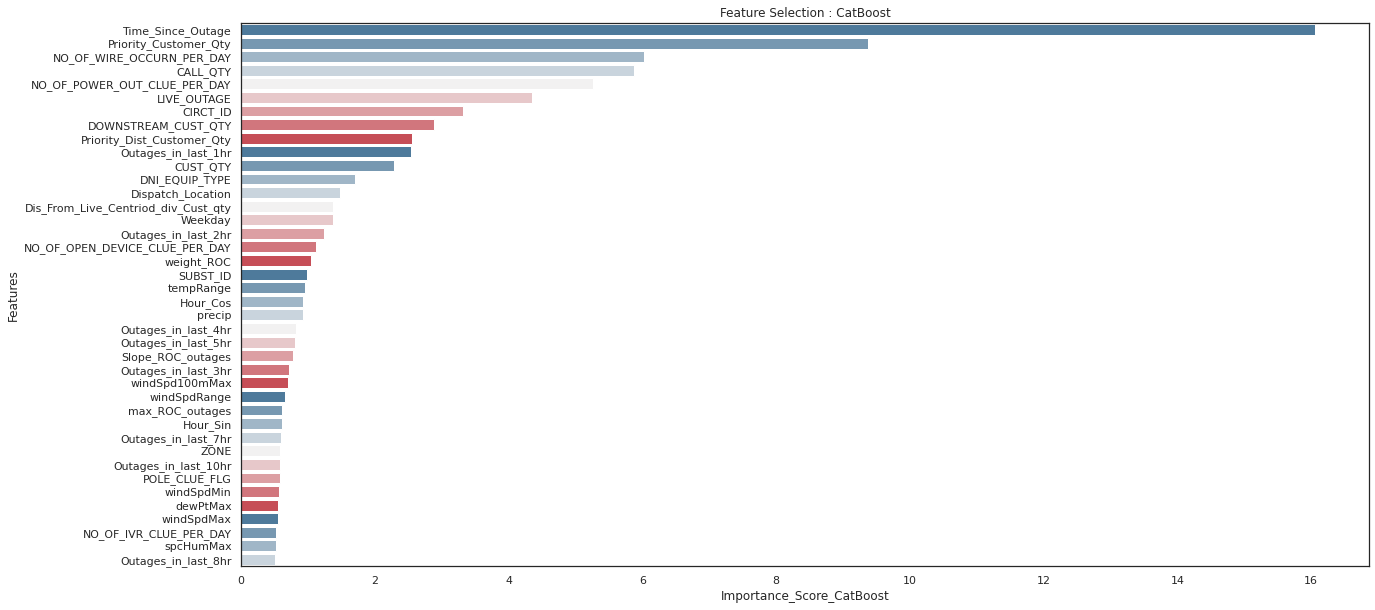

In [ ]:
sns.set(rc={'figure.figsize':(18,10)})
sns.set_style("white")
ax = sns.barplot(x="Importance_Score_CatBoost", y="Features", data=catboost, palette = sns.diverging_palette(240, 10, n=9)).set_title('Feature Selection : CatBoost')

In [ ]:
final_features = list(catboost.Features)

### **View Data-set after feature selection**

In [ ]:
ads_v1 = load_ads[final_features]
ads_v1['TR'] = load_ads['TR']
display(ads_v1.head())

,Time_Since_Outage,Priority_Customer_Qty,NO_OF_WIRE_OCCURN_PER_DAY,CALL_QTY,NO_OF_POWER_OUT_CLUE_PER_DAY,LIVE_OUTAGE,CIRCT_ID,DOWNSTREAM_CUST_QTY,Priority_Dist_Customer_Qty,Outages_in_last_1hr,CUST_QTY,DNI_EQUIP_TYPE,Dispatch_Location,Dis_From_Live_Centriod_div_Cust_qty,Weekday,Outages_in_last_2hr,NO_OF_OPEN_DEVICE_CLUE_PER_DAY,weight_ROC,SUBST_ID,tempRange,Hour_Cos,precip,Outages_in_last_4hr,Outages_in_last_5hr,Slope_ROC_outages,Outages_in_last_3hr,windSpd100mMax,windSpdRange,max_ROC_outages,Hour_Sin,Outages_in_last_7hr,ZONE,Outages_in_last_10hr,POLE_CLUE_FLG,windSpdMin,dewPtMax,windSpdMax,NO_OF_IVR_CLUE_PER_DAY,spcHumMax,Outages_in_last_8hr,TR
1,0.00,1.00,1,2,7,1,1958,6.00,1.00,0,6.00,1TBOH,MILL,0.66,Monday,1,1,0.10,195,8.80,-0.71,0.00,1,1,-1.93,1,20.30,11.10,1,0.71,2,ZONE4,2,False,6.70,39.10,17.80,5,5.20,2,39.60
2,30.00,1.00,1,2,7,1,1958,6.00,1.00,0,6.00,1TBOH,MILL,0.66,Monday,1,1,0.10,195,8.80,-0.71,0.00,1,1,-1.93,1,20.30,11.10,1,0.71,2,ZONE4,2,False,6.70,39.10,17.80,5,5.20,2,9.60
3,0.00,2.00,1,1,7,0,1252,5.00,2.00,0,5.00,FUSE,MILL,1.05,Monday,0,1,0.40,125,9.20,-0.50,0.00,0,1,-1.13,0,20.20,11.10,1,0.87,1,ZONE4,1,False,6.70,39.10,17.80,5,5.20,1,108.17
4,30.00,2.00,1,1,7,0,1252,5.00,2.00,0,5.00,FUSE,MILL,1.05,Monday,0,1,0.40,125,9.20,-0.50,0.00,0,1,-1.13,0,20.20,11.10,1,0.87,1,ZONE4,1,False,6.70,39.10,17.80,5,5.20,1,78.17
5,60.00,2.00,1,1,7,0,1252,5.00,2.00,0,5.00,FUSE,MILL,1.05,Monday,0,1,0.40,125,9.20,-0.50,0.00,0,1,-1.13,0,20.20,11.10,1,0.87,1,ZONE4,1,False,6.70,39.10,17.80,5,5.20,1,48.17


## **Train-Test Split using sklearn**

In [ ]:
X = ads_v1[final_features]
y = ads_v1['TR']

# Split data for validation
x, x_hold, y, y_hold = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42)

# create eval set
x_train, x_val, y_train, y_val = train_test_split(
    x, y,
    test_size=0.2,
    stratify=y,
    random_state=42)

ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.

In [ ]:
categorical_features_indices = np.where((x_train.dtypes != np.int) & (x_train.dtypes != np.float))[0];
print(categorical_features_indices)

In [ ]:
object_columns = ads_v1.loc[:, (ads_v1.dtypes == object) | (ads_v1.dtypes == bool)]
print(list(object_columns.columns))

### **Building Parameter Tuned CatBoost Model**
- CatBoost is an algorithm for gradient boosting on decision trees.

In [ ]:
model_col = ['MODEL_NAME' , 'TRAIN_MSE', 'TRAIN_RMSE', 'TRAIN_MAE', 'TRAIN_MAPE', 'TRAIN_R2','TRAIN__Adj_R2', 'TEST_MSE', 'TEST_RMSE', 'TEST_MAE', 'TEST_MAPE', 'TEST_R2','Test__Adj_R2']
model_result_df = pd.DataFrame(columns=model_col)
data_train_list = pd.DataFrame()
data_test_list = pd.DataFrame()
i=0

In [ ]:
cat_base = CatBoostRegressor(silent=True)
cat_base.fit(x_train, y_train, eval_set=[(x_val, y_val)], early_stopping_rounds=20, use_best_model=True, cat_features=categorical_features_indices)

y_train_pred = cat_base.predict(x_train)
y_hold_pred = cat_base.predict(x_hold)

n = len(y_train)
p = len(final_features)

mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = rmse(y_train,y_train_pred)
mae_train = mean_absolute_error(y_train, y_train_pred)
mape_train = mean_absolute_percentage_error(y_train,y_train_pred)
r2_train = r2_score(y_train,y_train_pred)
adj_r2_train = 1-(1-r2_train)*(n-1)/(n-p-1)
                   
mse_test = mean_squared_error(y_hold, y_hold_pred)
rmse_test = rmse(y_hold,y_hold_pred)
mae_test = mean_absolute_error(y_hold, y_hold_pred)
mape_test = mean_absolute_percentage_error(y_hold,y_hold_pred)
r2_test = r2_score(y_hold,y_hold_pred)
adj_r2_test = 1-(1-r2_test)*(n-1)/(n-p-1)

data_train = pd.DataFrame({'Model':'CATB Baseline', 'Train_Predicted': list(y_train_pred),'Train_Actual': list(y_train) })
data_train_list = data_train_list.append(data_train)
data_train_list.reset_index(drop=True, inplace=True)

data_test = pd.DataFrame({'Model':'CATB Baseline', 'Test_Predicted': list(y_hold_pred),'Test_Actual': list(y_hold)})
data_test_list = data_test_list.append(data_test)
data_test_list.reset_index(drop=True, inplace=True)

model_result_df.loc[i] = ['CATB Baseline', mse_train, rmse_train, mae_train, mape_train, r2_train,adj_r2_train, mse_test, rmse_test, mae_test, mape_test, r2_test, adj_r2_test]
i = i + 1

In [ ]:
model_result_df.head()

## **CatBoost Base: Actual vs Fitted Plot**

In [ ]:
sns.set(rc={'figure.figsize':(18,7)})
sns.set_style("darkgrid")

ax = sns.regplot(x="Test_Actual", y="Test_Predicted", data=data_test_list[data_test_list.Model=='CATB Baseline'], line_kws={"color": "black"})
ax.set_xlim(0,3000)
ax.set_ylim(0,3000)
ax.set_title('Actual vs Fitted : CATB RS')
points = np.linspace(0, 7000, 100)
ax = sns.lineplot(points, points, color='orange', marker=None,linestyle='--', linewidth=2.0)

### **Randomized Search using CatBoost**

In [ ]:
grid_params = {'n_estimators': [int(x) for x in np.linspace(start = 1000, stop = 5000, num = 5)],
               'depth': [int(x) for x in np.linspace(3, 10, num = 5)],
               'l2_leaf_reg': [3,4,5,6],
               'leaf_estimation_iterations': [1,2,3,4]}

In [ ]:
%%time
cat_ran = CatBoostRegressor(silent=True)

cat_random = RandomizedSearchCV(estimator=cat_ran, param_distributions=grid_params, cv = 3, n_iter=30, verbose=True, n_jobs=-1)

cat_random.fit(x_train, y_train, eval_set=[(x_val, y_val)], early_stopping_rounds=20, cat_features=categorical_features_indices)

In [ ]:
print(cat_random.best_params_)

In [ ]:
df_results = pd.DataFrame(cat_random.cv_results_)

with open('best_params_site.csv', 'w') as csv_file:
    writer = csv.writer(csv_file)
    for key, value in cat_random.best_params_.items():
        writer.writerow([key, value])

with open("best_score_site.txt", "w") as txtfile:
    txtfile.write(f"Best Score = {cat_random.best_score_}")

print(cat_random.best_params_)
print(cat_random.best_score_)

In [ ]:
cat_rs = CatBoostRegressor(silent=True)
cat_rs.set_params(**cat_random.best_params_)
cat_rs.fit(x_train, y_train, eval_set=[(x_val, y_val)], early_stopping_rounds=20, use_best_model=True, cat_features=categorical_features_indices)

y_train_pred = cat_rs.predict(x_train)
y_hold_pred = cat_rs.predict(x_hold)

n = len(y_train)
p = len(final_features)

mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = rmse(y_train,y_train_pred)
mae_train = mean_absolute_error(y_train, y_train_pred)
mape_train = mean_absolute_percentage_error(y_train,y_train_pred)
r2_train = r2_score(y_train,y_train_pred)
adj_r2_train = 1-(1-r2_train)*(n-1)/(n-p-1)
                   
mse_test = mean_squared_error(y_hold, y_hold_pred)
rmse_test = rmse(y_hold,y_hold_pred)
mae_test = mean_absolute_error(y_hold, y_hold_pred)
mape_test = mean_absolute_percentage_error(y_hold,y_hold_pred)
r2_test = r2_score(y_hold,y_hold_pred)
adj_r2_test = 1-(1-r2_test)*(n-1)/(n-p-1)

data_train = pd.DataFrame({'Model':'CATB RS', 'Train_Predicted': list(y_train_pred),'Train_Actual': list(y_train) })
data_train_list = data_train_list.append(data_train)
data_train_list.reset_index(drop=True, inplace=True)

data_test = pd.DataFrame({'Model':'CATB RS', 'Test_Predicted': list(y_hold_pred),'Test_Actual': list(y_hold)})
data_test_list = data_test_list.append(data_test)
data_test_list.reset_index(drop=True, inplace=True)

model_result_df.loc[i] = ['CATB RS', mse_train, rmse_train, mae_train, mape_train, r2_train,adj_r2_train, mse_test, rmse_test, mae_test, mape_test, r2_test, adj_r2_test]
i = i + 1

In [ ]:
model_result_df.head()

## **CatBoost Random Search: Actual vs Fitted PLot**

In [ ]:
sns.set(rc={'figure.figsize':(18,7)})
sns.set_style("darkgrid")

ax = sns.regplot(x="Test_Actual", y="Test_Predicted", data=data_test_list[data_test_list.Model=='CATB RS'], line_kws={"color": "red"})
ax.set_xlim(0,3000)
ax.set_ylim(0,3000)
ax.set_title('Actual vs Fitted : CATB RS')
points = np.linspace(0, 3000, 100)
ax = sns.lineplot(points, points, color='black', marker=None,linestyle='--', linewidth=2.0)

## **Save Model Object**

In [ ]:
import gcsfs

fs = gcsfs.GCSFileSystem(project='aes-datahub-0002')
fs.ls('aes-datahub-0002-curated/Outage_Restoration/Historical_Data/PickleFiles')
with fs.open('aes-datahub-0002-curated/Outage_Restoration/Historical_Data/PickleFiles/IPL_TTR_Catboost_11272020.pkl', 'wb') as f:
    pickle.dump(cat_rs, f)

## **Better Visualization**

In [ ]:
data_test_list

In [ ]:
def segment_storm(x):
    if(x<=120):
        return "0-120", 1
    elif(x<=240):
        return "120-240", 2
    elif(x<=360):
        return "240-360", 3
    elif(x<=480):
        return "360-480", 4
    elif(x<=600):
        return "480-600", 5
    elif(x<=720):
        return "600-720", 6
    elif(x<=840):
        return "720-840", 7
    elif(x<=960):
        return "840-960", 8
    elif(x<=1080):
        return "960-1080", 9
    elif(x<=1200):
        return "1080-1200", 10
    elif(x<=1320):
        return "1200-1320", 11
    elif(x<=1440):
        return "1320-1440", 12
    else:
        return ">1440", 13
    
data_test_list['Actual_Bucket'], data_test_list['size'] = zip(*data_test_list['Test_Actual'].apply(segment_storm))

In [ ]:
sns.set(rc={'figure.figsize':(18,7)})
sns.set_style("whitegrid")
ax = sns.scatterplot(data=data_test_list[data_test_list.Model=='CATB RS'], x="Test_Predicted", y="Test_Actual", hue="Actual_Bucket", size="size", sizes=(30, 100))
points = np.linspace(0, 3000, 100)
ax = sns.lineplot(points, points, color='black', marker=None,linestyle='--', linewidth=2.0)
h,l = ax.get_legend_handles_labels()
plt.legend(h[0:14],l[0:14], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title='Actual vs Predicted')

## **2020 out of Sample Validation**

In [ ]:
from scipy.stats import linregress

# load 2020 dataset
df_ads_2020 = pd.read_csv('gs://aes-analytics-0002-curated/Outage_Restoration/Historical_Data/Master_Dataset/OMS_IPL_2020_11162020.csv')
df_ads_2020['Time_Since_Outage'] = 0

# add features
def feature_add(group):
    group = group.reset_index(drop = True)
    x = [group.Outages_in_last_1hr[0],group.Outages_in_last_2hr[0],group.Outages_in_last_3hr[0],group.Outages_in_last_4hr[0],group.Outages_in_last_5hr[0]
        ,group.Outages_in_last_6hr[0],group.Outages_in_last_7hr[0],group.Outages_in_last_8hr[0],group.Outages_in_last_9hr[0],group.Outages_in_last_10hr[0]]
    y = [1,2,3,4,5,6,7,8,9,10]
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    group['Slope_outages'] = slope
    
    ROC = [abs(group.Outages_in_last_1hr[0] - group.Outages_in_last_2hr[0]),abs(group.Outages_in_last_2hr[0] - group.Outages_in_last_3hr[0]),
           abs(group.Outages_in_last_3hr[0] - group.Outages_in_last_4hr[0]),abs(group.Outages_in_last_4hr[0] - group.Outages_in_last_5hr[0]),
           abs(group.Outages_in_last_5hr[0] - group.Outages_in_last_6hr[0]),abs(group.Outages_in_last_6hr[0] - group.Outages_in_last_7hr[0]),
           abs(group.Outages_in_last_7hr[0] - group.Outages_in_last_8hr[0]),abs(group.Outages_in_last_8hr[0] - group.Outages_in_last_9hr[0]),
           abs(group.Outages_in_last_9hr[0] - group.Outages_in_last_10hr[0])]
    y = [1,2,3,4,5,6,7,8,9]
    slope, intercept, r_value, p_value, std_err = linregress(ROC, y)
    group['Slope_ROC_outages'] = slope
    
    group['max_ROC_outages'] = max(ROC)
    group['max_index_ROC'] = 1+ROC.index(max(ROC))    
    group['weight_ROC'] = group['max_ROC_outages'] * group['max_index_ROC']*0.1
    return group

In [ ]:
df_ads_2020 = df_ads_2020.groupby(['OUTAGE_ID'], as_index = False).apply(feature_add).reset_index(drop = True)
df_ads_2020 = df_ads_2020.dropna(axis=0, subset=['Slope_outages', 'Slope_ROC_outages'])
df_ads_2020 = df_ads_2020[df_ads_2020.TTR>30]
df_ads_2020 = df_ads_2020[df_ads_2020.TTR<5000]

In [ ]:
storm_col = ['MODEL_NAME' , 'TEST_MSE', 'TEST_RMSE', 'TEST_MAE', 'TEST_MAPE', 'TEST_R2']
storm_result_df = pd.DataFrame(columns=storm_col)
storm_test_list = pd.DataFrame() 
i=0

In [ ]:
X = df_ads_2020[final_features]
y = df_ads_2020.TTR

y_test_pred = cat_rs.predict(X)

mse_test = mean_squared_error(y, y_test_pred)
rmse_test = rmse(y,y_test_pred)
mae_test = mean_absolute_error(y, y_test_pred)
mape_test = mean_absolute_percentage_error(y,y_test_pred)
r2_test = r2_score(y,y_test_pred)

data_test = pd.DataFrame({'Model':'CatBoost2020', 'Test_Predicted': list(y_test_pred),'Test_Actual': list(y)})
storm_test_list = storm_test_list.append(data_test)
storm_test_list.reset_index(drop=True, inplace=True)

storm_result_df.loc[i] = ['CatBoost2020', mse_test, rmse_test, mae_test, mape_test, r2_test]
i = i + 1

In [ ]:
storm_result_df

In [ ]:
def segment_storm(x):
    if(x<=120):
        return "0-120", 1
    elif(x<=240):
        return "120-240", 2
    elif(x<=360):
        return "240-360", 3
    elif(x<=480):
        return "360-480", 4
    elif(x<=600):
        return "480-600", 5
    elif(x<=720):
        return "600-720", 6
    elif(x<=840):
        return "720-840", 7
    elif(x<=960):
        return "840-960", 8
    elif(x<=1080):
        return "960-1080", 9
    elif(x<=1200):
        return "1080-1200", 10
    elif(x<=1320):
        return "1200-1320", 11
    elif(x<=1440):
        return "1320-1440", 12
    else:
        return ">1440", 13
    
storm_test_list['Actual_Bucket'], storm_test_list['size'] = zip(*storm_test_list['Test_Actual'].apply(segment_storm))

In [ ]:
sns.set(rc={'figure.figsize':(18,7)})
sns.set_style("whitegrid")
ax = sns.scatterplot(data=storm_test_list[storm_test_list.Model=='CatBoost2020'], x="Test_Predicted", y="Test_Actual", hue="Actual_Bucket", size="size", sizes=(30, 100))
points = np.linspace(0, 3000, 100)
ax = sns.lineplot(points, points, color='black', marker=None,linestyle='--', linewidth=2.0)
h,l = ax.get_legend_handles_labels()
plt.legend(h[0:14],l[0:14], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title='Actual vs Predicted')

## **Nov 15th Storm Out of Sample Validation**

In [ ]:
df_nov15 = pd.read_csv('gs://aes-datahub-0002-curated/Outage_Restoration/IPL_Master_Dataset/OMS_15Nov_Storm.csv')
df_nov15['Time_Since_Outage'] = 0

In [ ]:
X = df_nov15[final_features]
y = df_nov15.TTR

y_test_pred = cat_rs.predict(X)

mse_test = mean_squared_error(y, y_test_pred)
rmse_test = rmse(y,y_test_pred)
mae_test = mean_absolute_error(y, y_test_pred)
mape_test = mean_absolute_percentage_error(y,y_test_pred)
r2_test = r2_score(y,y_test_pred)

data_test = pd.DataFrame({'Model':'CatBoost', 'Test_Predicted': list(y_test_pred),'Test_Actual': list(y)})
storm_test_list = storm_test_list.append(data_test)
storm_test_list.reset_index(drop=True, inplace=True)

storm_result_df.loc[i] = ['CatBoost', mse_test, rmse_test, mae_test, mape_test, r2_test]
i = i + 1

In [ ]:
storm_result_df

In [ ]:
def segment_storm(x):
    if(x<=120):
        return "0-120", 1
    elif(x<=240):
        return "120-240", 2
    elif(x<=360):
        return "240-360", 3
    elif(x<=480):
        return "360-480", 4
    elif(x<=600):
        return "480-600", 5
    elif(x<=720):
        return "600-720", 6
    elif(x<=840):
        return "720-840", 7
    elif(x<=960):
        return "840-960", 8
    elif(x<=1080):
        return "960-1080", 9
    elif(x<=1200):
        return "1080-1200", 10
    elif(x<=1320):
        return "1200-1320", 11
    elif(x<=1440):
        return "1320-1440", 12
    else:
        return ">1440", 13
    
storm_test_list['Actual_Bucket'], storm_test_list['size'] = zip(*storm_test_list['Test_Actual'].apply(segment_storm))

In [ ]:
sns.set(rc={'figure.figsize':(18,7)})
sns.set_style("whitegrid")
ax = sns.scatterplot(data=storm_test_list[storm_test_list.Model=='CatBoost'], x="Test_Predicted", y="Test_Actual", hue="Actual_Bucket", size="size", sizes=(30, 100))
points = np.linspace(0, 3000, 100)
ax = sns.lineplot(points, points, color='black', marker=None,linestyle='--', linewidth=2.0)
h,l = ax.get_legend_handles_labels()
plt.legend(h[0:14],l[0:14], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title='Actual vs Predicted')

### Adding Aligned Business Layer

In [ ]:
def business_layer_add_addtional_time(predicted_values):
    '''
    Input - Prediction of Outages in minutes
    Output - If predicted values are less than 1440 min
    Add 45 mins to predictions, Else Add 360 mins to predictions
    '''
    new_pred_values = []
    for i in range(len(predicted_values)):
        if predicted_values[i] <= 1440:
            new_pred_values.append(predicted_values[i] + 45)
        elif predicted_values[i] > 1440:
            new_pred_values.append(predicted_values[i] + 360)
        else :
            new_pred_values.append(predicted_values[i])
    return new_pred_values

pred_business = business_layer_add_addtional_time(list(storm_test_list['Test_Predicted']))
storm_test_list['Test_Predicted'] = pred_business

In [ ]:
sns.set(rc={'figure.figsize':(18,7)})
sns.set_style("whitegrid")
ax = sns.scatterplot(data=storm_test_list[storm_test_list.Model=='CatBoost'], x="Test_Predicted", y="Test_Actual", hue="Actual_Bucket", size="size", sizes=(30, 100))
points = np.linspace(0, 3000, 100)
ax = sns.lineplot(points, points, color='black', marker=None,linestyle='--', linewidth=2.0)
h,l = ax.get_legend_handles_labels()
plt.legend(h[0:14],l[0:14], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title='Actual vs Predicted')